# 2.0 Train model and save the results

Setup

In [1]:
import torch

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: mps


## Prepare data

Define dataset parameters and transforms

In [3]:
from torchvision import transforms

train_mean = [0.3186241388320923, 0.2931755483150482, 0.3017965853214264]
train_std = [0.2762017846107483, 0.2654302418231964, 0.2686000168323517]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

Load the dataset

In [4]:
from torchvision.datasets import ImageFolder

train_dir = "./data/train"
train_ds = ImageFolder(train_dir, transform=transform)

num_classes = len(train_ds.classes)

print(f"Number of train images: {len(train_ds)}")
print(f"Number of train classes: {num_classes}")

Number of train images: 31367
Number of train classes: 43


Prepare data loaders

In [5]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

## Create model

Define the latent space

In [6]:
latent_dim = 100

Define the model

In [7]:
from gnn import Generator, Discriminator

generator = Generator(num_classes, latent_dim=latent_dim).to(device)
discriminator = Discriminator(num_classes).to(device)

## Train model

Define training parameters

In [8]:
import torch.optim as optim
import torch.nn as nn

G_lr = 4e-4
D_lr = 1e-4

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=G_lr)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
adv_criterion = nn.MSELoss()
cls_criterion = nn.CrossEntropyLoss()

Train the model

Epoch 0: 100%|██████████| 246/246 [00:18<00:00, 13.51it/s]


D_fake_acc=0.163, D_real_acc=0.837


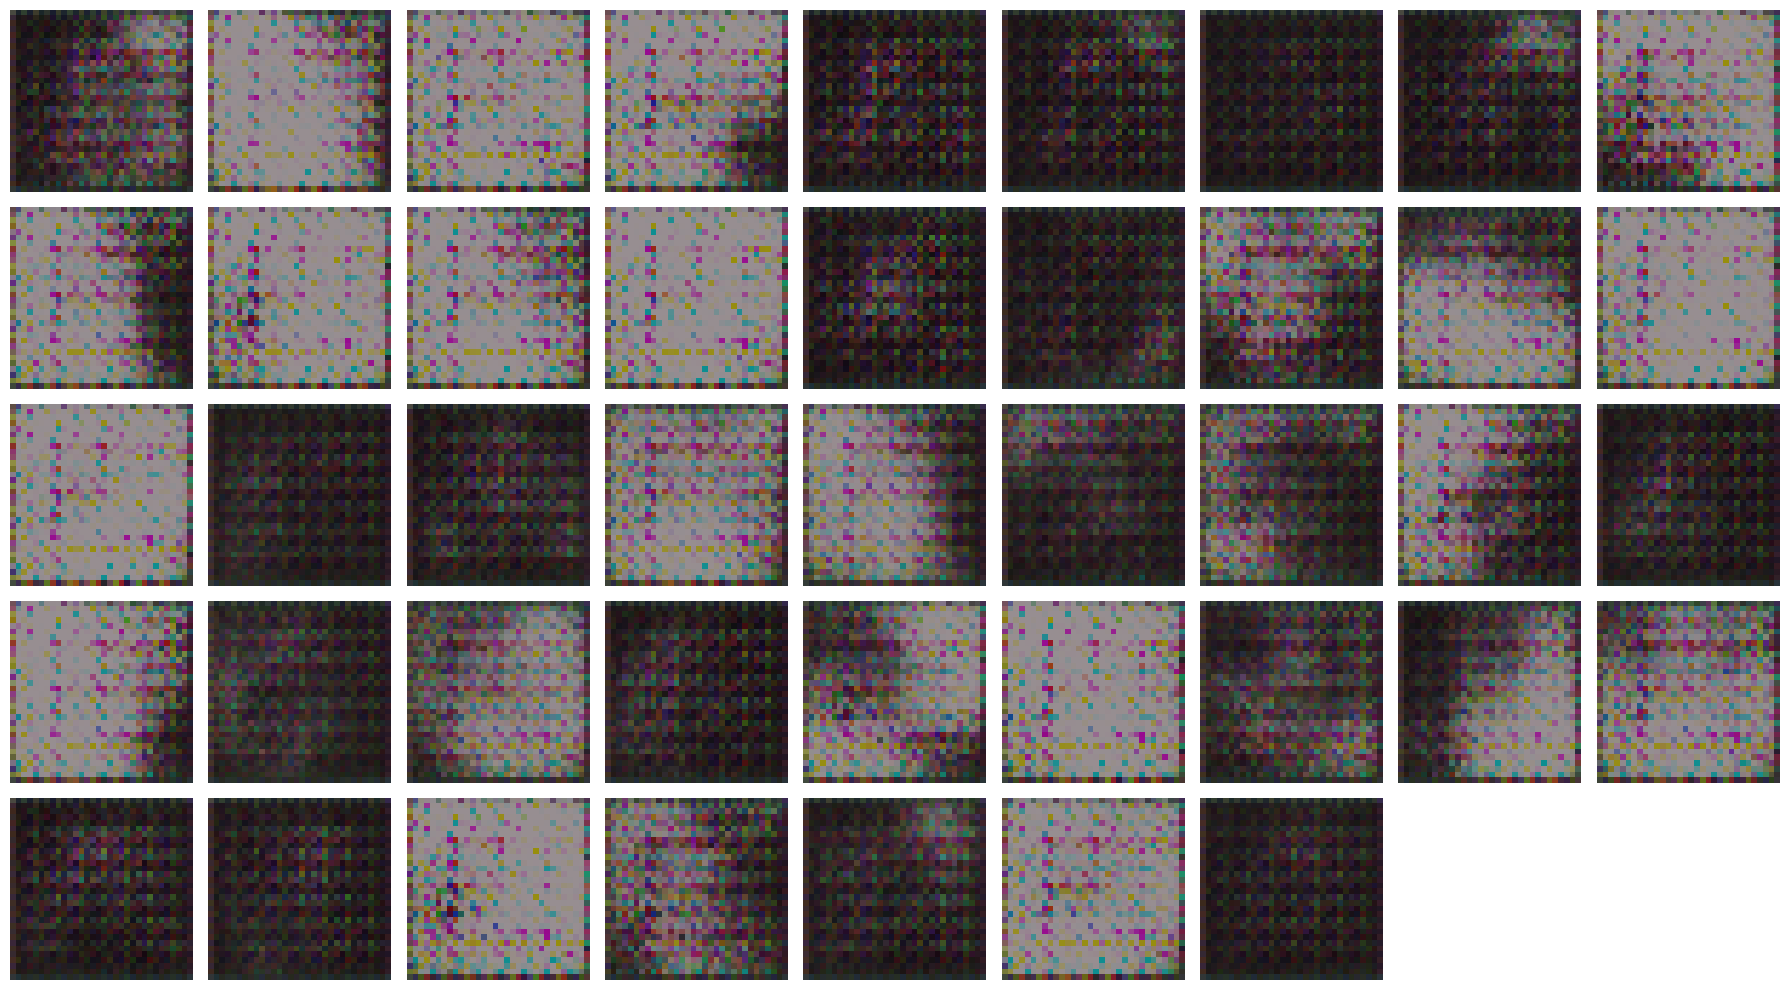

Epoch 1: 100%|██████████| 246/246 [00:15<00:00, 15.91it/s]


D_fake_acc=0.080, D_real_acc=0.909


Epoch 2: 100%|██████████| 246/246 [00:15<00:00, 16.04it/s]


D_fake_acc=0.061, D_real_acc=0.940


Epoch 3: 100%|██████████| 246/246 [00:15<00:00, 16.12it/s]


D_fake_acc=0.053, D_real_acc=0.944


Epoch 4: 100%|██████████| 246/246 [00:15<00:00, 16.19it/s]


D_fake_acc=0.049, D_real_acc=0.952


Epoch 5: 100%|██████████| 246/246 [00:15<00:00, 16.16it/s]


D_fake_acc=0.043, D_real_acc=0.957


Epoch 6: 100%|██████████| 246/246 [00:15<00:00, 15.95it/s]


D_fake_acc=0.036, D_real_acc=0.958


Epoch 7: 100%|██████████| 246/246 [00:15<00:00, 15.97it/s]


D_fake_acc=0.027, D_real_acc=0.966


Epoch 8: 100%|██████████| 246/246 [00:15<00:00, 16.12it/s]


D_fake_acc=0.034, D_real_acc=0.970


Epoch 9: 100%|██████████| 246/246 [00:13<00:00, 17.65it/s]


D_fake_acc=0.020, D_real_acc=0.980


Epoch 10: 100%|██████████| 246/246 [00:14<00:00, 16.42it/s]


D_fake_acc=0.019, D_real_acc=0.977


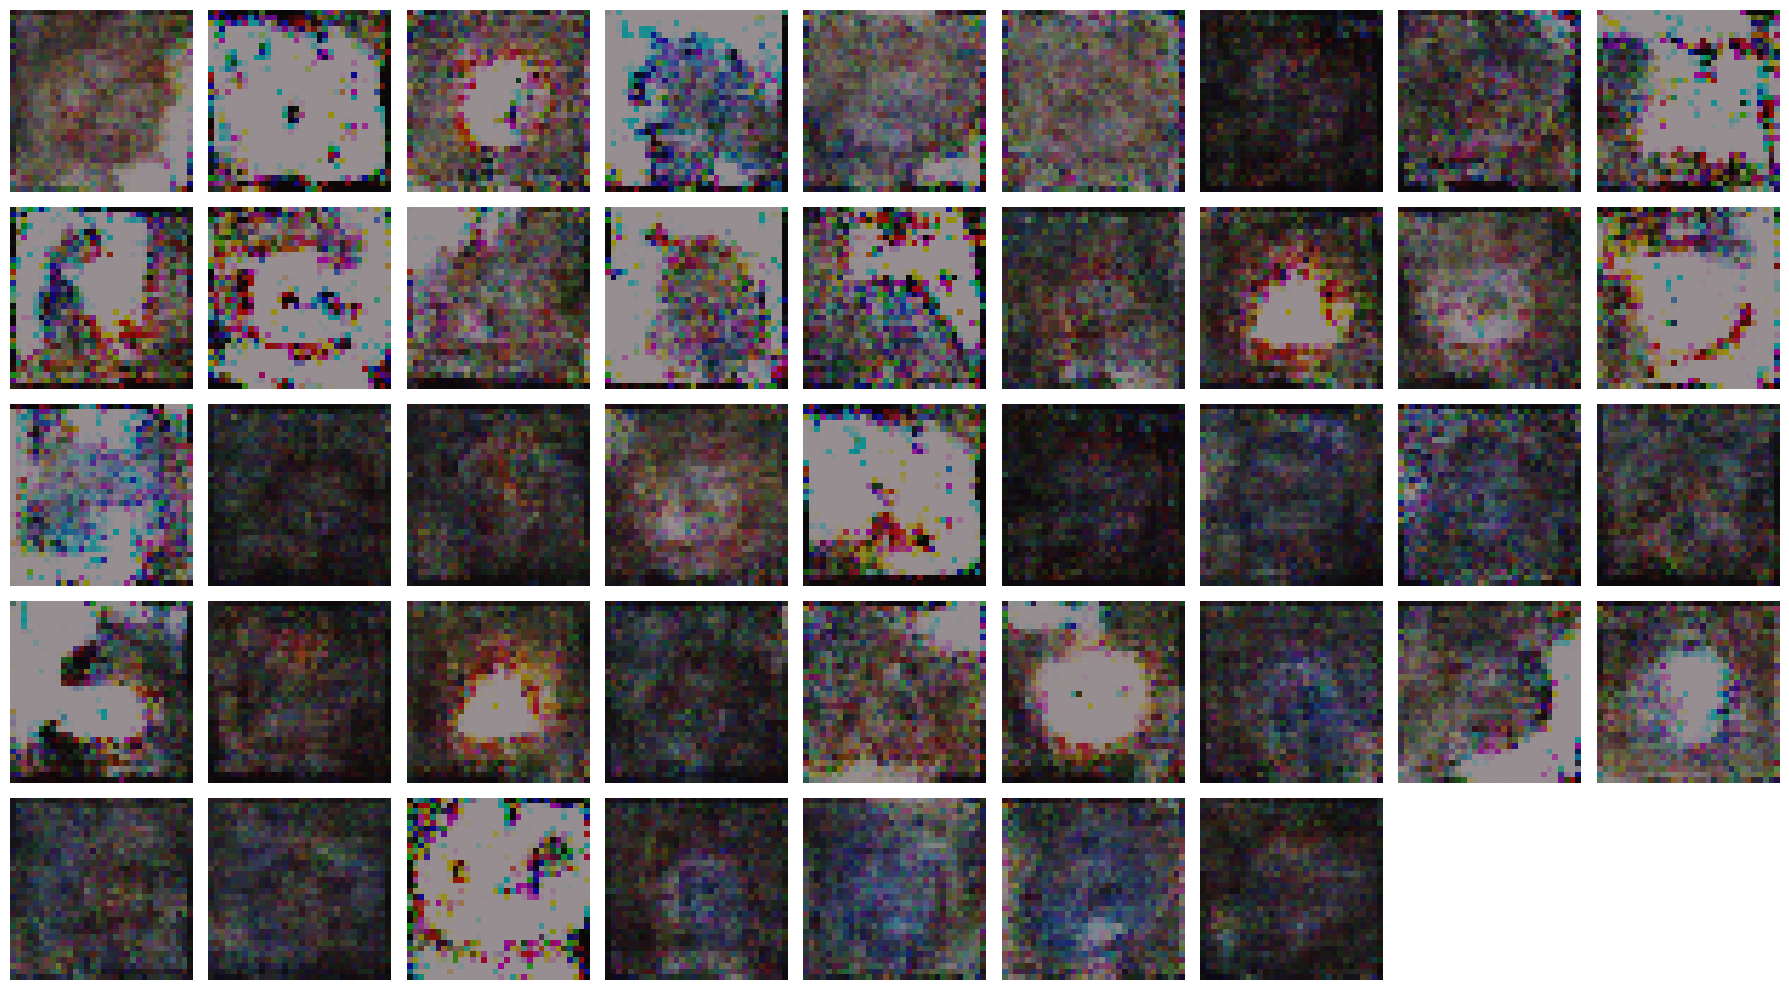

Epoch 11: 100%|██████████| 246/246 [00:15<00:00, 16.20it/s]


D_fake_acc=0.018, D_real_acc=0.983


Epoch 12: 100%|██████████| 246/246 [00:14<00:00, 17.24it/s]


D_fake_acc=0.020, D_real_acc=0.980


Epoch 13: 100%|██████████| 246/246 [00:14<00:00, 16.42it/s]


D_fake_acc=0.015, D_real_acc=0.984


Epoch 14: 100%|██████████| 246/246 [00:13<00:00, 17.93it/s]


D_fake_acc=0.011, D_real_acc=0.986


Epoch 15: 100%|██████████| 246/246 [00:14<00:00, 17.44it/s]


D_fake_acc=0.014, D_real_acc=0.985


Epoch 16: 100%|██████████| 246/246 [00:15<00:00, 16.13it/s]


D_fake_acc=0.011, D_real_acc=0.983


Epoch 17: 100%|██████████| 246/246 [00:15<00:00, 16.14it/s]


D_fake_acc=0.027, D_real_acc=0.977


Epoch 18: 100%|██████████| 246/246 [00:15<00:00, 15.71it/s]


D_fake_acc=0.011, D_real_acc=0.984


Epoch 19: 100%|██████████| 246/246 [00:15<00:00, 16.23it/s]


D_fake_acc=0.013, D_real_acc=0.985


Epoch 20: 100%|██████████| 246/246 [00:14<00:00, 16.63it/s]


D_fake_acc=0.017, D_real_acc=0.988


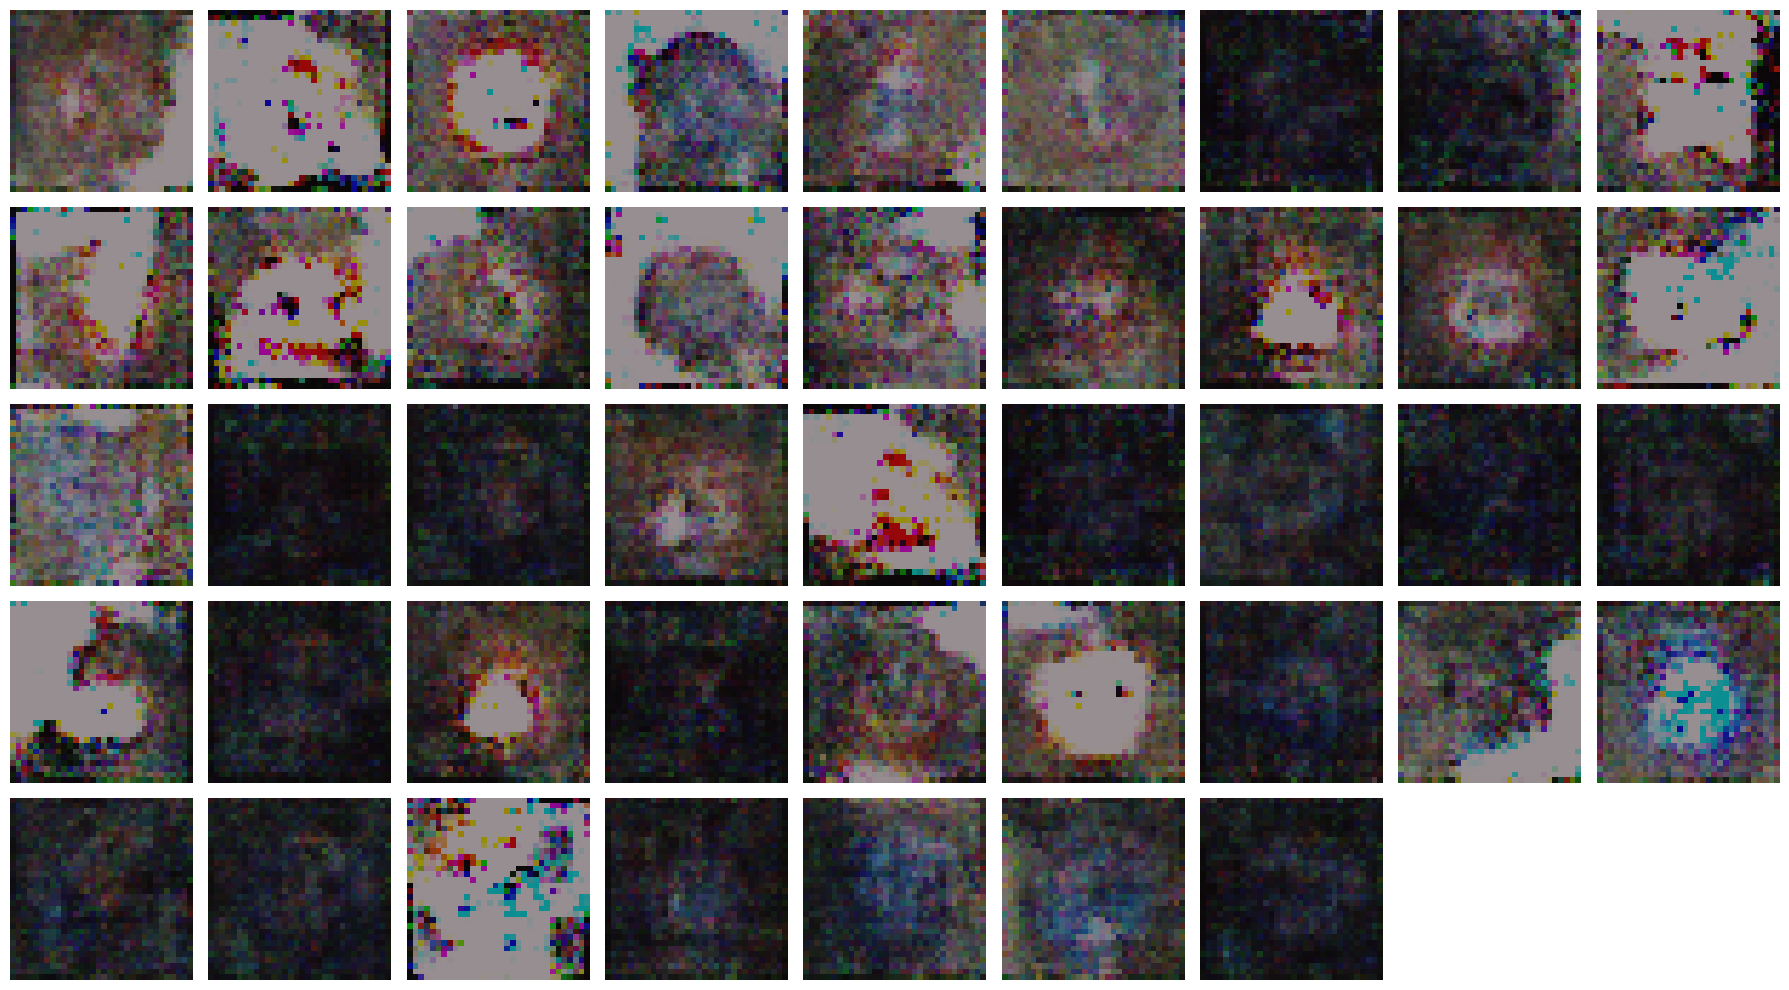

Epoch 21: 100%|██████████| 246/246 [00:14<00:00, 16.53it/s]


D_fake_acc=0.009, D_real_acc=0.986


Epoch 22: 100%|██████████| 246/246 [00:15<00:00, 16.10it/s]


D_fake_acc=0.008, D_real_acc=0.991


Epoch 23: 100%|██████████| 246/246 [00:15<00:00, 16.17it/s]


D_fake_acc=0.007, D_real_acc=0.990


Epoch 24: 100%|██████████| 246/246 [00:15<00:00, 15.57it/s]


D_fake_acc=0.011, D_real_acc=0.992


Epoch 25: 100%|██████████| 246/246 [00:15<00:00, 16.03it/s]


D_fake_acc=0.007, D_real_acc=0.988


Epoch 26:  49%|████▉     | 120/246 [00:07<00:08, 15.56it/s]

In [ ]:
from gnn import Trainer as GNNTrainer

gnn_trainer = GNNTrainer(num_classes, adversarial_criterion=adv_criterion, classification_criterion=cls_criterion, latent_dim=latent_dim, device=device)
gnn_trainer.set_generator(generator, generator_optimizer, generator_scheduler)
gnn_trainer.set_discriminator(discriminator, discriminator_optimizer, discriminator_scheduler)

# Training
loss = gnn_trainer.fit(train_dl, num_epochs=100, mean=train_mean, std=train_std)

## Evaluation

Calculate the FID between test set and generated images

In [12]:
from pytorch_fid.fid_score import calculate_fid_given_paths

test_dir = "./data/test_flat"
generated_dir = test_dir # TODO: replace when generated images are available

fid = calculate_fid_given_paths([test_dir, generated_dir], batch_size, device, dims=2048, num_workers=1)

print(f"FID: {fid}")

100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


FID: -2.034922431448649e-06
